# Setup

In [1]:
import matplotlib.dates as mdates
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import matplotlib.style as style
import os
import pandas as pd
import seaborn as sns

In [2]:
latam_palette = sns.color_palette()

In [3]:
style.use("fivethirtyeight")

In [4]:
root_path = "/Users/jmcontreras/jm-contreras/"
countries_path = os.path.join(root_path, "COVID-19/csse_covid_19_data")
data_path = os.path.join(root_path, "COVID-19/csse_covid_19_data/csse_covid_19_daily_reports")
plots_path = os.path.join(root_path, "bolivia-covid-19/daily_plots")

In [5]:
latam_countries = [
    "Argentina",
    "Bolivia",
    "Brazil",
    "Chile",
    "Colombia",
    "Ecuador",
    "Paraguay",
    "Peru",
    "Uruguay",
    "Venezuela",
]

In [6]:
def get_data(country_filter):

    df = pd.DataFrame()

    # Get all files in the data path
    fname_list = os.listdir(path=data_path)
    fname_list.sort()

    for fname in fname_list:

        if fname.endswith(".csv"):

            # Read CSV
            df_fname = pd.read_csv(
                os.path.join(data_path, fname)
            )

            # Filter to specific row(s) based on country
            col_filter = df_fname.columns.values[df_fname.columns.str.contains("Country")][0]
            df_fname_filter = df_fname[df_fname[col_filter].isin(country_filter)]

            # Append to single dataframe
            df = pd.concat(
                (df, df_fname_filter),
            )
            
    return df


def clean_data(df):
    
    # Make a copy of the input data
    df = df.copy(deep=True)

    # Find columns missing all data and add them to a list of columns to drop
    is_null_all = df.isnull().all()
    cols_to_drop = is_null_all[is_null_all].index.tolist()

    # Coalesce country/region and last update columns
    df["Country_Region"].update(df["Country/Region"])
    df["Last_Update"].update(df["Last Update"])

    # Extend the list of columns to drop
    cols_to_drop.extend(
        [
            "Latitude",
            "Longitude",
            "Lat",
            "Long_",
            "Combined_Key",
            "Last Update",
            "Country/Region",
        ]
    )

    # Drop these columns
    df.drop(columns=cols_to_drop, inplace=True)
    
    # Drop rows without any quantitative data
    df.dropna(how="all", subset=["Confirmed", "Deaths", "Recovered", "Active"], inplace=True)
    
    # Recast dates as datetime
    df["Last_Update"] = pd.to_datetime(df["Last_Update"])
    
    # Drop duplicates and reset the index
    df.drop_duplicates(inplace=True)
    
    return df


def prep_data(df):
    
    def fill_missing_add_new_count_days(x):
    
        # Fill-in missing dates and forward-fill missing values
        x = x.reindex(
            labels=pd.date_range(
                start=x.index.min(),
                end=x.index.max(),),
            method="ffill"
        )
        
        # Add new cases column
        x["New"] = x["Confirmed"].diff().fillna(value=x.iloc[0]["Confirmed"])
        
        # Add days since first confirmed column
        x["Day_Count"] = (x.index - x.index.min()).days
    
        return x
    
    df = df.copy(deep=True)

    df.set_index(df["Last_Update"].dt.date, inplace=True)
    df.index.name = "Date"
    
    # For dates with multiple rows, keep their most recent row
    df = df.groupby(
        by=["Date", "Country_Region"],
        group_keys=False,
    ).apply(
        lambda x: x.sort_values(["Last_Update", "Confirmed"]).tail(n=1),
    )
    
    # Fill-in missing dates, forward-fill missing values, and create new column
    df = df.groupby(
        by="Country_Region"
    ).apply(
        fill_missing_add_new_count_days
    ).reset_index(
        level="Country_Region",
        drop=True,
    )
    
    return df

# Load population data

In [7]:
df_population = pd.read_csv(
    os.path.join(countries_path, "UID_ISO_FIPS_LookUp_Table.csv")
)

# Load, clean, and prepare data

In [8]:
# Bolivia
df_bo = get_data(["Bolivia"])
df_bo = clean_data(df_bo)
df_bo = prep_data(df_bo)

# Latin America
df_latam = get_data(latam_countries)
df_latam = clean_data(df_latam)
df_latam = prep_data(df_latam)

# Plot Bolivia graph

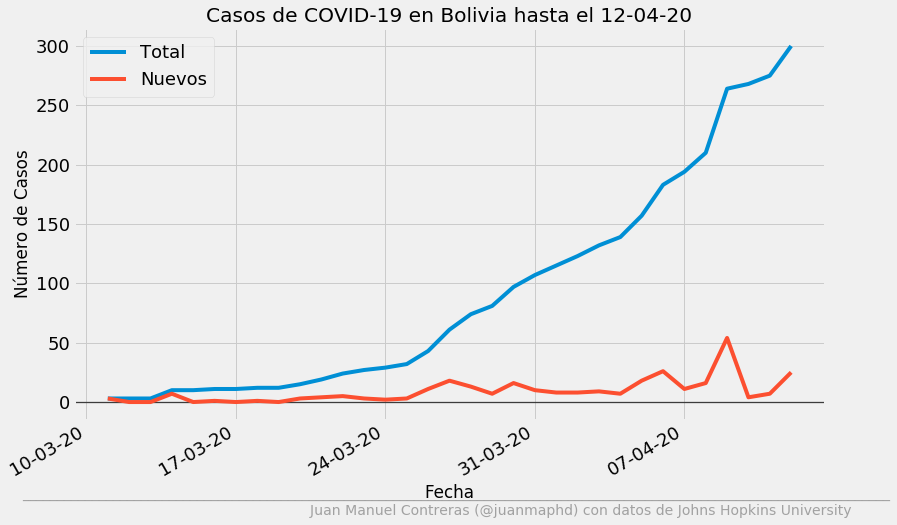

In [9]:
# Create plot object
ax = df_bo.plot(
    y=["Confirmed", "New"],
    title=f"Casos de COVID-19 en Bolivia hasta el {df_bo.index.max().strftime('%d-%m-%y')}",
    legend=True,
    x_compat=True,
    figsize = (12, 8),
)

# Format x-axis ticks and tick labels
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y"))
ax.tick_params(
    axis="both",
    which="major",
    labelsize=18,
)

# Format labels
plt.ylabel("Número de Casos")
plt.xlabel("Fecha")
plt.legend(["Total", "Nuevos"], fontsize=18)

# Add thicker horizontal axis
ax.axhline(
    y=0,
    color="black",
    linewidth=1.3,
    alpha=0.7,
    zorder=1,
)

# Add subtitle
offset = 1
line = "_" * (int(df_bo.shape[0] * 3.8) - offset)
signature = "Juan Manuel Contreras (@juanmaphd) con datos de Johns Hopkins University"
ax.text(
    x=df_bo.index.min() - pd.Timedelta(days=4),
    y=-95,
    s=f"{line}\n{' ' * (int(df_bo.shape[0] * 1.98) - offset)}{signature}",
    color="grey",
    alpha=.7
)

# Draw plot
plt.show()

# Save plot
ax.get_figure().savefig(os.path.join(plots_path, f"bolivia_{df_bo.index.max().strftime('%d_%m_%y')}.png"))

# Plot Latin America graph

In [10]:
# Join to country population
df_latam = df_latam.reset_index().merge(
    df_population[["Country_Region", "Population"]],
    on="Country_Region",
    how="inner"
).set_index("index")

# Compute confirmed per 100k
df_latam["Confirmed_Per_100k"] = df_latam["Confirmed"] / df_latam["Population"] * 100000

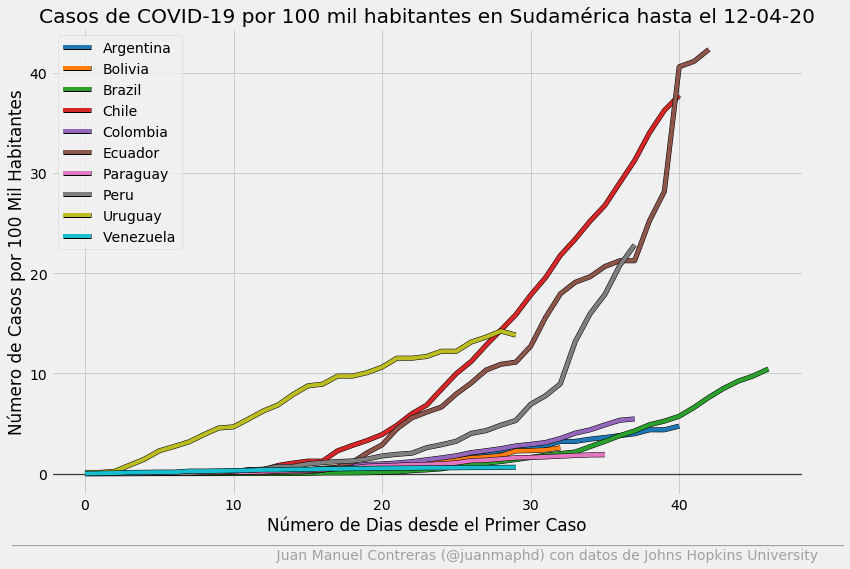

In [20]:
# Create plot object
fig, ax = plt.subplots(figsize=(12, 8))

# Draw plots
for i, key_grp in enumerate(df_latam.groupby(['Country_Region'])):
    key, grp = key_grp
    grp.plot(
        x="Day_Count",
        y="Confirmed_Per_100k",
        label=key,
        ax=ax,
        color=latam_palette[i],
        path_effects=[
            pe.Stroke(linewidth=5, foreground='black'),
            pe.Normal()
        ],
    )

# Add title and axes labels
plt.title(f"Casos de COVID-19 por 100 mil habitantes en Sudamérica hasta el {df_latam.index.max().strftime('%d-%m-%y')}",)
plt.ylabel("Número de Casos por 100 Mil Habitantes")
plt.xlabel("Número de Dias desde el Primer Caso")

# Add thicker horizontal axis
ax.axhline(
    y=0,
    color="black",
    linewidth=1.3,
    alpha=0.7,
    zorder=1,
)

# Add subtitle
offset = 1
line = "_" * (int(df_latam["Day_Count"].max() * 2.6))
signature = "Juan Manuel Contreras (@juanmaphd) con datos de Johns Hopkins University"
ax.text(
    x=-5,
    y=-8.5,
    s=f"{line}\n{' ' * (int(df_latam['Day_Count'].max() * 1.3))}{signature}",
    color="grey",
    alpha=.7
)

# Draw plot
plt.show()

# Save plot
ax.get_figure().savefig(os.path.join(plots_path, f"latam_{df_bo.index.max().strftime('%d_%m_%y')}.png"))